## Test pure-H2 convective shutdown

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.plotting as plotting

AGNI.setup_logging("",1)

In [4]:
F_earth = 1361.0
R_earth = 6.371e6
M_earth = 5.97e24

5.97e24

In [5]:
# Configuration options
instellation    = F_earth * (1/3.5)^2
mass            = M_earth
radius          = R_earth     
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 0.1        

s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_s        = 0.3
nlev_centre     = 35
p_top           = 1e-3      # bar 
mole_fractions  = Dict([("H2",  1.0)])
tmp_surf        = 500.0
thermo          = true

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Dayspring/256/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [6]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [7]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, 0.0, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        surface_material="blackbody",
                        albedo_s=albedo_s
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2      1.00e+00  


In [8]:
@printf("Instellation = %.2f W m-2 \n", atmos.instellation )

Instellation = 111.10 W m-2 


In [10]:
prs_arr = collect(range(start=0.0, stop=1.25, step=0.25))  # log(bar)
# prs_arr = collect(range(start=-1, stop=4, step=1))  # log(bar)
atm_arr = atmosphere.Atmos_t[]

nsamp = length(prs_arr)

@printf("Running model for %d samples... \n", nsamp)

dx_max::Float64 = 200.0
modulate_mlt::Bool = false
linesearch::Int = 1

atmos.tmp_surf = 800.0
setpt.loglinear!(atmos, 50.0)

for (i,prs) in enumerate(prs_arr)
    @printf("sample %d/%d \n",i,nsamp)

    prs = 10.0^prs
    @printf("    pressure = %.1f bar \n", prs)

    atmos.p_boa = prs * 1.0e5 
    atmos.pl[end] = atmos.p_boa
    atmosphere.generate_pgrid!(atmos)

    if i > 1
        dx_max = 100.0
        modulate_mlt = false

        atmos.tmpl[:] .+= 50.0
        atmos.tmp[:]  .+= 50.0
    end 
    
    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=dx_max,
                                    ls_method=linesearch ,   
                                    save_frames=false, modplot=1,
                                    modprint=1, perturb_all=false,
                                    conv_atol=0.05, modulate_mlt=modulate_mlt 
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 6 samples... 
sample 1/6 
    pressure = 1.0 bar 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  +8.60e-02  4.325e+03  4.343e+03  3.201e+02  6.155e+02  1.902e+02  C2-Nr-Ls 
[ INFO  ]        2  +2.81e-02  1.321e+03  1.340e+03  2.556e+02  4.772e+02  1.389e+02  C2-Nr-Ls 
[ INFO  ]        3  +1.45e-02  7.684e+02  7.866e+02  2.354e+02  4.290e+02  4.901e+01  C2-Nr-Ls 
[ INFO  ]        4  -3.14e-03  4.500e+02  4.682e+02  2.199e+02  3.889e+02  4.132e+01  C2-Nr-Ls 
[ INFO  ]        5  -1.06e-01  3.286e+02  2.824e+02  2.085e+02  3.536e+02  3.702e+01  C2-Nr-Ls 
[ INFO  ]        6  -2.84e-01  1.968e+02  1.749e+02  1.962e+02  3.231e+02  3.180e+01  C2-Nr-Ls 
[ INFO  ]        7  -3.11e-01  1.847e+02  1.654e+02  1.940e+02  3.198e+02  3.312e+00  C2-Nr-Ls 
[ INFO  ]        8  -3.27e-01  1.789e+02  1.610e+02  1.930e+02  3.182

In [11]:
fs=12
lw=1.5
ff="Times New Roman"

"Times New Roman"

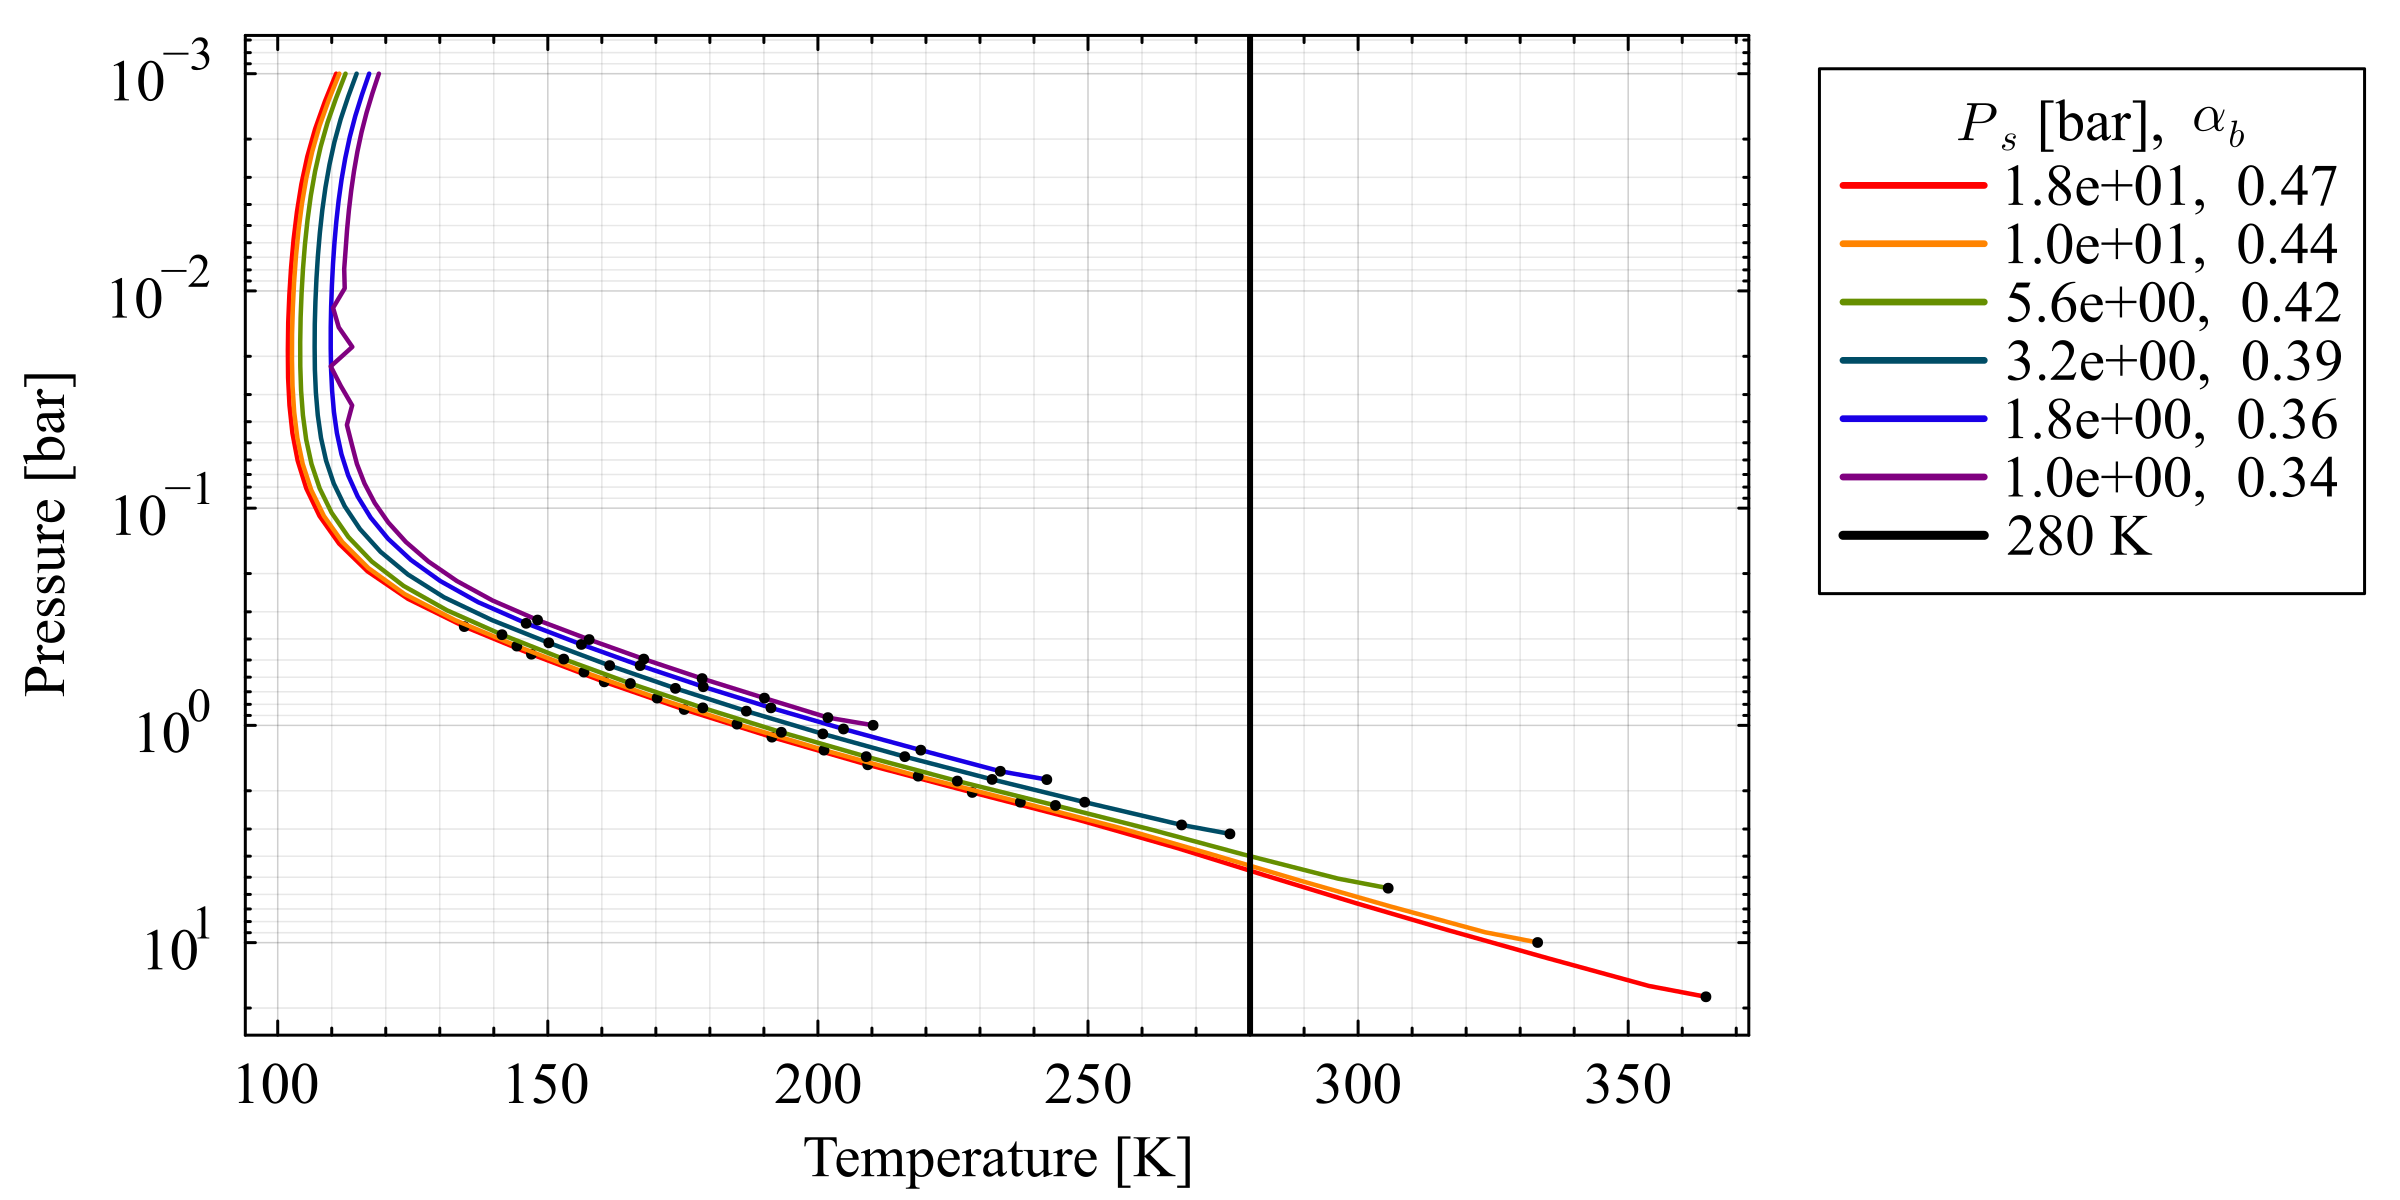

"/Users/nichollsh/Projects/AGNI/out/profiles.pdf"

In [12]:
ylims  = (p_top/1.5, 10.0^maximum(prs_arr)*1.5)
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(800,400), dpi=300, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, tickfontfamily=ff,
                guidefontsize=fs, guidefontfamily=ff,
                legendfontfamily=ff, legendfontsize=fs, 
                legendtitlefontfamily=ff, legendtitlefontsize=fs,
                leg_title=L"$P_s$ [bar],  $\alpha_b$",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)
          

p = Plots.palette(:rainbow, nsamp)
for i in range(start=nsamp, stop=1, step=-1)
    this_atm = atm_arr[i]
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%.1e,  %.2f", 10.0^prs_arr[i], this_atm.flux_u_sw[1]/this_atm.flux_d_sw[1]))
    mask = falses(this_atm.nlev_l)
    mask[:] .= (this_atm.flux_cdry .> 0.0)
    scatter!(plt, this_atm.tmpl[mask], this_atm.pl[mask]*1e-5, markercolor="black", label="", markersize=2.0)
end 

vline!(plt, [280.0], lc="black", label="280 K", lw=2.0)

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

In [13]:
for (i, atm) in enumerate(atm_arr)
    dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
end